# LinkedIn


## Setup


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from openai import OpenAI

In [2]:
client = OpenAI()

## Utilities


In [3]:
def load_generated_data(file_path, prompt):
    """
    Load data from a JSON file or generate it using OpenAI's API if it doesn't exist,
    using the OpenAI API key set as an environment variable.

    :param file_path: Path to the JSON file where data is stored or will be saved.
    :param prompt: The prompt to send to OpenAI if data needs to be generated.
    :return: The data loaded from the disk or generated by OpenAI.
    """
    # Convert string path to a Path object if necessary
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path

    # Check if the data file exists
    if file_path.exists():
        # Load and return the data from the file
        with open(file_path, "r") as file:
            data = json.load(file)
        return data
    else:
        # Request the data from OpenAI
        completion = client.chat.completions.create(
            model="gpt-4-turbo-preview",
            response_format="json_object",
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant. All of your responses are raw JSON.",
                },
                {"role": "user", "content": prompt},
            ],
        )

        # Extract the generated data
        data = completion.choices[0].message["content"] if completion.choices else {}

        # Save the generated data to the disk
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(file_path, "w") as file:
            json.dump(data, file)

        return data


def load_parquet(file_path, columns=None):
    """
    This function loads a parquet file directly if it exists. If a CSV file is provided,
    it checks for an existing corresponding parquet file. If the parquet file does not exist,
    it converts the CSV to parquet and saves it with a '.parquet.gzip' extension, then loads it.

    Parameters:
    - file_path: str, the path to the input file (either .csv or .parquet.gzip)

    Returns:
    - DataFrame loaded from the parquet file.
    """
    path = Path(file_path)

    if path.suffix == ".csv":
        parquet_path = path.with_suffix(".parquet.gzip")

        if not parquet_path.exists():
            df = pd.read_csv(path)
            df.to_parquet(parquet_path, compression="gzip")
        # else:
        #     print(f"Parquet file already exists for {file_path}, loading it directly.")
    elif path.suffix == ".gzip" and path.suffixes[-2] == ".parquet":
        parquet_path = path
    else:
        raise ValueError(
            "Unsupported file format. Please provide a .csv or .parquet.gzip file."
        )

    return pd.read_parquet(parquet_path, columns=columns)

## Data


In [4]:
job_skills_df = load_parquet(
    "./datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/job_skills.csv"
)
job_summaries_df = load_parquet(
    "./datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/job_summary.csv"
)
job_postings_df = load_parquet(
    "./datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/linkedin_job_postings.csv",
    columns=[
        "job_title",
        "company",
        "job_location",
        "search_city",
        "search_country",
        "search_position",
        "job_level",
        "job_type",
        "first_seen",
        "last_processed_time",
        "job_link",
    ],
)
companies_7m_df = load_parquet(
    "./datasets/peopledatalabssf/free-7-million-company-dataset/companies_sorted.csv",
    columns=["name", "industry"],
)
if not Path("./data/unique_companies.parquet.gzip").exists():
    unique_companies_df = (
        companies_7m_df.groupby("name")["industry"]
        .agg(lambda x: list(x.unique()))
        .reset_index()
    )
    unique_companies_df.to_parquet(
        "./data/unique_companies.parquet.gzip", compression="gzip"
    )
else:
    unique_companies_df = load_parquet("./data/unique_companies.parquet.gzip")

In [5]:
job_postings_df["company_lower"] = job_postings_df["company"].str.lower()
jobs_df = job_postings_df.merge(
    unique_companies_df, how="left", left_on="company_lower", right_on="name"
)

In [6]:
skills_df = job_skills_df[["job_link"]]
skills_df["job_skills"] = job_skills_df["job_skills"].str.split(", ")
skills_df = skills_df.set_index("job_link").explode("job_skills")

In [7]:
company_job_openings = jobs_df["company"].value_counts()
top_50_companies = company_job_openings.head(50)

## Questions


### What companies have the most job openings?


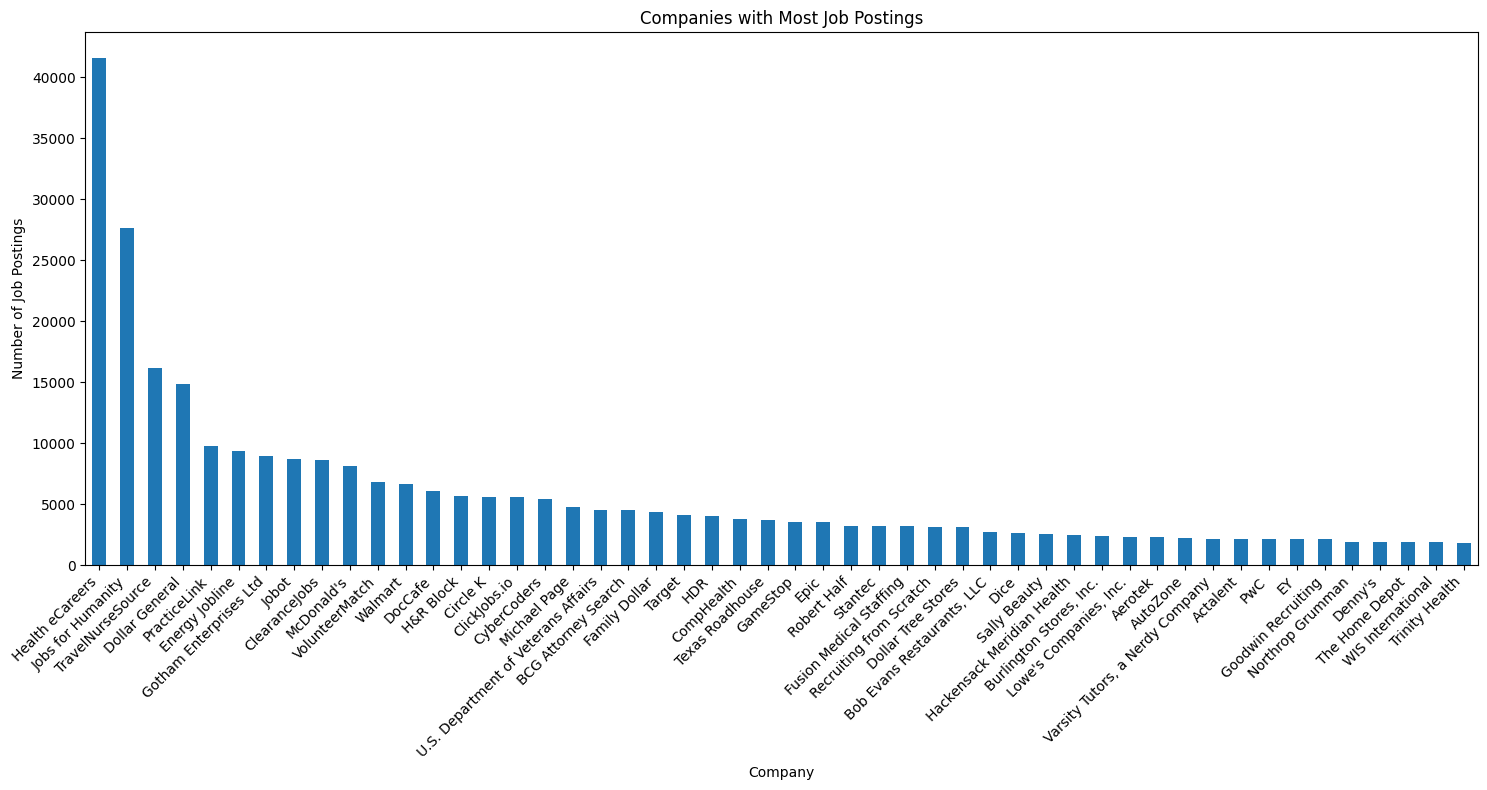

In [8]:
plt.figure(figsize=(15, 8))
top_50_companies.plot(kind="bar")
plt.title("Companies with Most Job Postings")
plt.xlabel("Company")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Which industries have the most job postings?


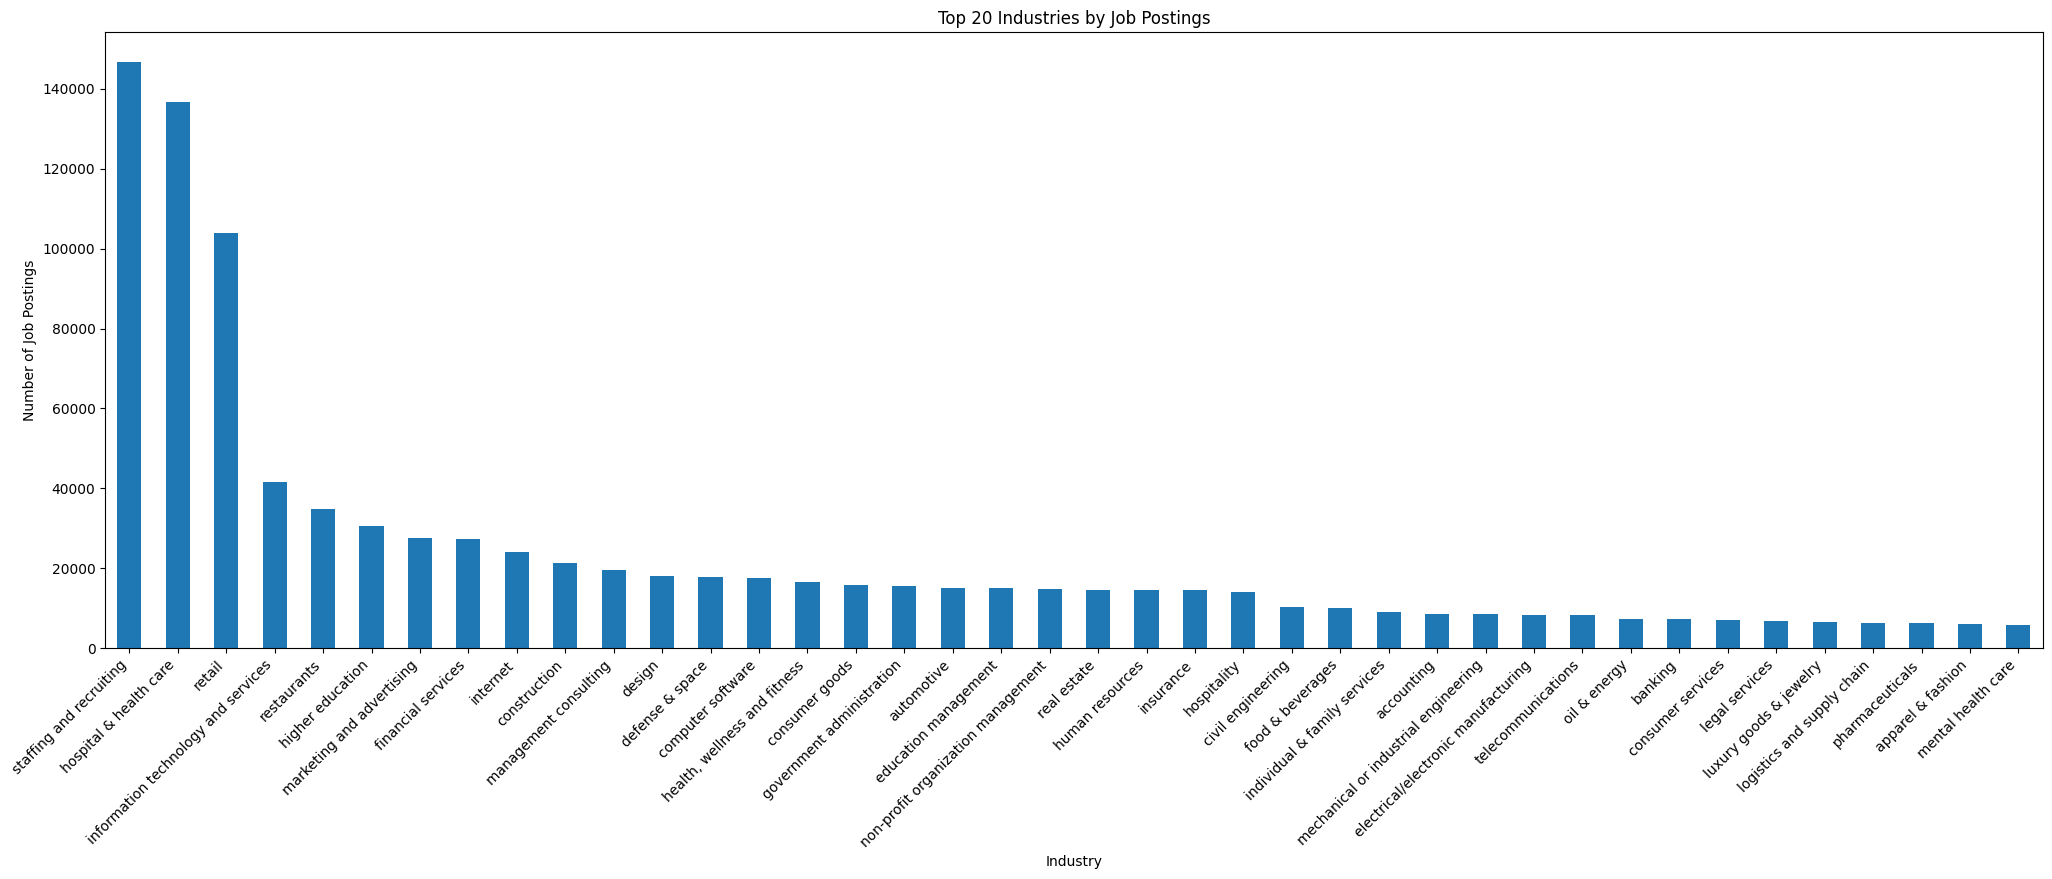

In [9]:
exploded_industry = jobs_df["industry"].explode()
industry_counts = exploded_industry.value_counts()
top_n = industry_counts.head(40)
plt.figure(figsize=(25, 8))
top_n.plot(kind="bar")
plt.title("Top 20 Industries by Job Postings")
plt.ylabel("Number of Job Postings")
plt.xlabel("Industry")
plt.xticks(rotation=45, ha="right")
plt.show()

### What are the most requested job roles?


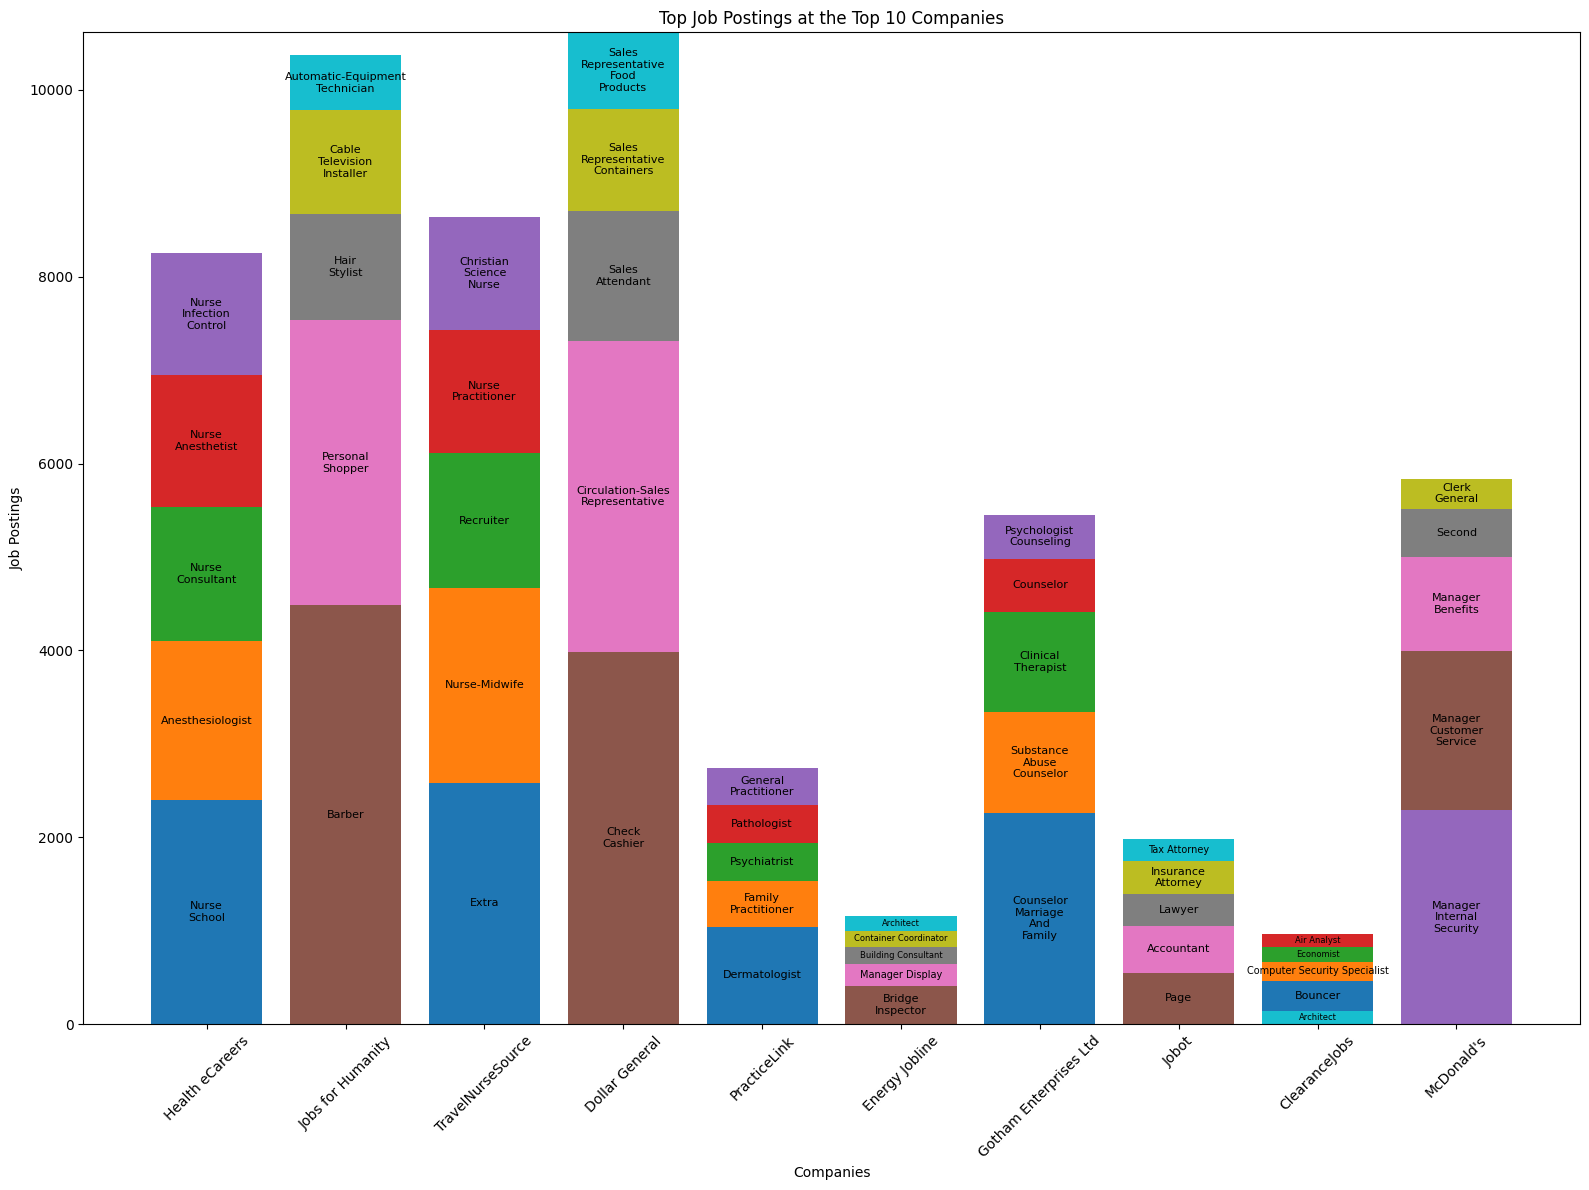

In [10]:
top_10_companies = jobs_df["company"].value_counts().nlargest(10).index
visualization_df = pd.DataFrame(index=top_10_companies)
for company in top_10_companies:
    company_df = jobs_df[jobs_df["company"] == company]
    top_jobs = company_df["search_position"].value_counts().nlargest(5)

    for job_title, count in top_jobs.items():
        if job_title not in visualization_df.columns:
            visualization_df[job_title] = 0

        visualization_df.at[company, job_title] = count

visualization_df = visualization_df.fillna(0)

fig, ax = plt.subplots(figsize=(16, 12))

bottom = np.zeros(len(visualization_df))


def adjust_font_size(value, base_size=8):
    if value > 250:
        return base_size
    elif value > 200:
        return max(base_size - 1, 6)
    else:
        return max(base_size - 2, 4)


for col in visualization_df.columns:
    ax.bar(visualization_df.index, visualization_df[col], bottom=bottom, label=col)
    for i, value in enumerate(visualization_df[col]):
        if value > 0:
            if value > 250:
                label = "\n".join(col.split())
            else:
                label = col
            font_size = adjust_font_size(value)
            x_pos = i
            y_pos = bottom[i] + value / 2
            plt.text(
                x_pos,
                y_pos,
                label,
                ha="center",
                va="center",
                fontsize=font_size,
                rotation=0,
            )

    bottom += visualization_df[col].values

plt.title("Top Job Postings at the Top 10 Companies")
plt.xlabel("Companies")
plt.ylabel("Job Postings")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### What are the needs in technology related industries?


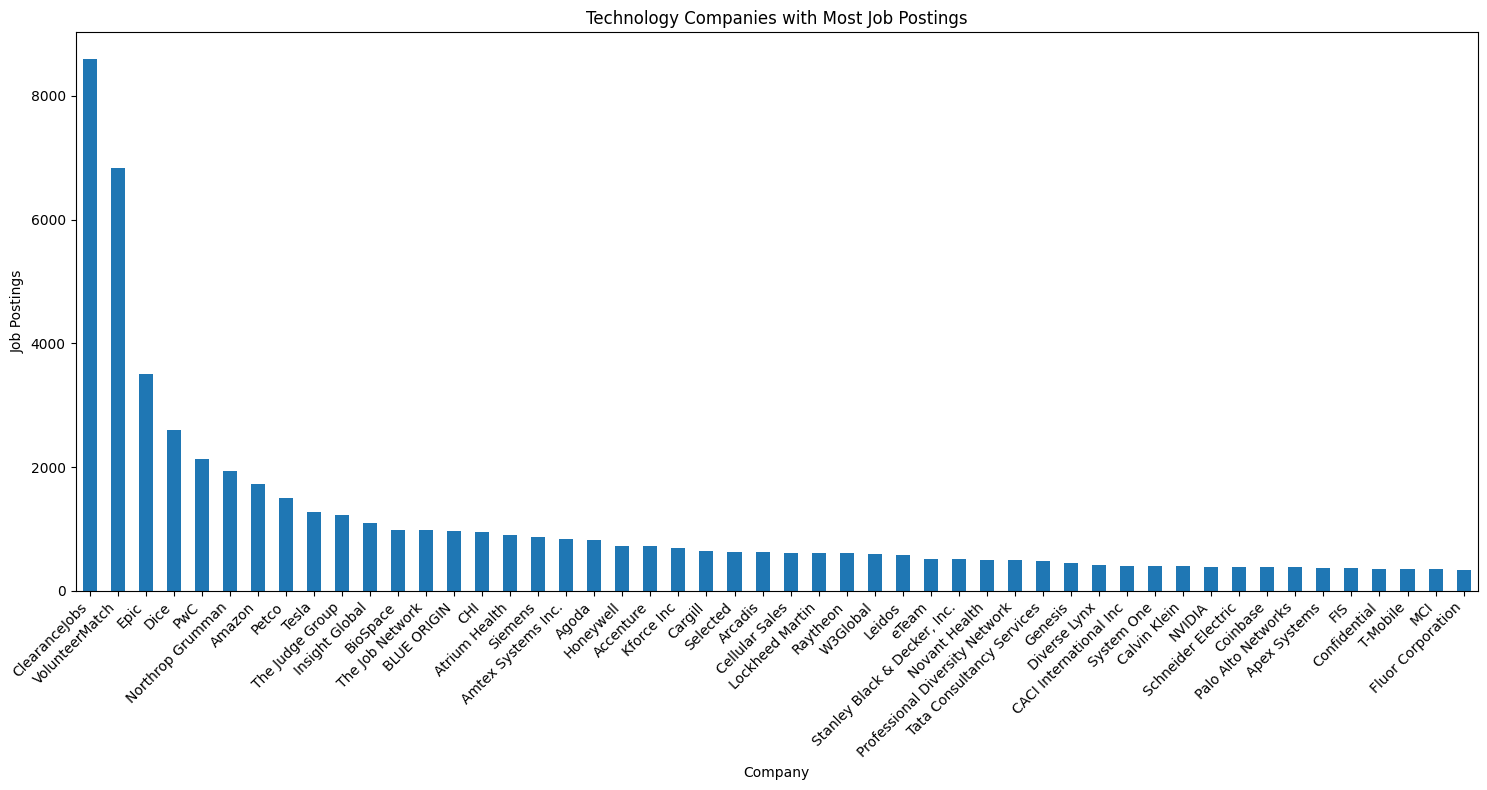

In [29]:
technology_related_industries = [
    "information technology and services",
    "computer software",
    "telecommunications",
    "defense & space",
    "internet",
    "consumer electronics",
    "electrical/electronic manufacturing",
    "semiconductors",
    "computer networking",
    "computer hardware",
    "information services",
    "wireless",
    "industrial automation",
    "computer & network security",
    "e-learning",
    "online media",
    "computer games",
    "animation",
    "nanotechnology",
]
technology_related_jobs_df = jobs_df[jobs_df["industry"].notna()]
technology_related_mask = technology_related_jobs_df["industry"].apply(
    lambda x: any(industry in technology_related_industries for industry in x)
)
technology_related_jobs_df = technology_related_jobs_df[technology_related_mask]
technology_related_jobs_counts = (
    technology_related_jobs_df["company"].value_counts().head(50)
)

plt.figure(figsize=(15, 8))
technology_related_jobs_counts.plot(kind="bar")
plt.title("Technology Companies with Most Job Postings")
plt.xlabel("Company")
plt.ylabel("Job Postings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()